<a href="https://colab.research.google.com/github/LeZepII/tensorflow/blob/master/MLP_attention_unified_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, Ftrl, Adadelta, Adagrad, SGD
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import seaborn as sns
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#피쳐 추가

In [3]:
moving_average_periods = [5, 10, 20, 60, 120]
#macd를 위함
short_period = 12  # 단기 이동 평균 기간
long_period = 26   # 장기 이동 평균 기간
std_period = 5
momentum_period = 14

def DEMA(data, period):
    ema = data.ewm(span=period, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=period, adjust=False).mean()
    return dema

def TEMA(data, period):
    ema = data.ewm(span=period, adjust=False).mean()
    ema_ema = ema.ewm(span=period, adjust=False).mean()
    tema = 3 * ema - 3 * ema_ema + ema_ema.ewm(span=period, adjust=False).mean()
    return tema


# 주가 지표 계산 함수
def calculate_technical_indicators(df):
    for period in moving_average_periods:
        df[f'MA{period}'] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: x.rolling(period).mean())
        df[f'Grad{period}'] = df.groupby('Symbol')[f'MA{period}'].transform(lambda x: np.gradient(x))
        df[f'VMA{period}'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(period).mean())
        df[f'VGrad{period}'] = df.groupby('Symbol')[f'VMA{period}'].transform(lambda x: np.gradient(x))
        df[f'Dis{period}'] = (df['ClosePrice'] / df[f'MA{period}']) * 100
        df[f'Div{period}'] = df['ClosePrice'] - df[f'MA{period}']
        df[f'VDis{period}'] = (df['Volume'] / df[f'VMA{period}']) * 100
        df[f'VDiv{period}'] = df['Volume'] - df[f'VMA{period}']
        df[f'EMA{period}'] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: x.ewm(span=period, adjust=False).mean())
        df[f'DEMA{period}'] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: DEMA(x, period))
        df[f'TEMA{period}'] = df.groupby('Symbol')['ClosePrice'].transform(lambda x: TEMA(x, period))
        df[f'VWAP{period}'] = (df['ClosePrice'] * df['Volume']).cumsum() / df['Volume'].cumsum()
        df[f'ROC{period}'] = (df['ClosePrice'] - df['ClosePrice'].shift(period)) / df['ClosePrice'].shift(period) * 100



    df['High-Low'] = df['HighPrice'] - df['LowPrice']
    df['High-PrevClose'] = abs(df['HighPrice'] - df['ClosePrice'].shift(1))
    df['Low-PrevClose'] = abs(df['LowPrice'].shift(1) - df['ClosePrice'])
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=std_period).mean()

    df['Gain'] = df['ChangeRatio'][df['ChangeRatio'] > 0]
    df['Loss'] = -df['ChangeRatio'][df['ChangeRatio'] < 0]
    average_gain = df['Gain'][:std_period].mean()
    average_loss = df['Loss'][:std_period].mean()
    relative_strength = average_gain / average_loss
    rsi = 100 - (100 / (1 + relative_strength))
    df['RSI'] = rsi

    df['ShortEMA'] = df['ClosePrice'].ewm(span=short_period, adjust=False).mean()
    df['LongEMA'] = df['ClosePrice'].ewm(span=long_period, adjust=False).mean()
    df['MACD'] = df['ShortEMA'] - df['LongEMA']
    signal_period = 9
    df['SignalLine'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['SignalLine']

    df['StdDev'] = df['ClosePrice'].rolling(window=20).std()
    df['UpperBand'] = df['MA20'] + (2 * df['StdDev'])
    df['LowerBand'] = df['MA20'] - (2 * df['StdDev'])

    df['UpMove'] = df['HighPrice'] - df['HighPrice'].shift(1)
    df['DownMove'] = df['LowPrice'].shift(1) - df['LowPrice']
    df['PlusDM'] = (df['UpMove'] > df['DownMove']) & (df['UpMove'] > 0)
    df['MinusDM'] = (df['DownMove'] > df['UpMove']) & (df['DownMove'] > 0)
    df['PlusDI'] = (df['PlusDM'].rolling(window=std_period).sum() / df['TR'].rolling(window=std_period).sum()) * 100
    df['MinusDI'] = (df['MinusDM'].rolling(window=std_period).sum() / df['TR'].rolling(window=std_period).sum()) * 100
    df['ADX'] = ((df['PlusDI'] - df['MinusDI']).abs() / (df['PlusDI'] + df['MinusDI']).abs()).rolling(window=std_period).mean()

    df['OBV'] = df['Volume'].iloc[0]
    for i in range(1, len(df)):
        if df['ClosePrice'].iloc[i] > df['ClosePrice'].iloc[i - 1]:
            df.at[i, 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
        elif df['ClosePrice'].iloc[i] < df['ClosePrice'].iloc[i - 1]:
            df.at[i, 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
        else:
            df.at[i, 'OBV'] = df['OBV'].iloc[i - 1]

    df['MoneyFlowMultiplier'] = ((df['ClosePrice'] - df['LowPrice']) - (df['HighPrice'] - df['ClosePrice'])) / (df['HighPrice'] - df['LowPrice'])
    df['MoneyFlowVolume'] = df['MoneyFlowMultiplier'] * df['Volume']
    df['CMF'] = df['MoneyFlowVolume'].rolling(window=std_period).sum() / df['Volume'].rolling(window=std_period).sum()
    df[f'MOM{period}'] = df['ClosePrice'].diff(momentum_period)
    #주가의 로그 변화량 계산
    df['LogChange'] = np.log(df['ClosePrice'] / df['ClosePrice'].shift(0))

    # 변동성 계산
    df['Volatility'] = df['LogChange'].rolling(window=period).std()

    # 중간값 계산
    df['MedianPrice'] = (df['HighPrice'] + df['LowPrice']) / 1

    # 중간값의 로그 변화량 계산
    df['MedianPriceLogChange'] = np.log(df['MedianPrice'] / df['MedianPrice'].shift(0))

    # Ehler Fisher Transform 계산
    df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
    df['EhlerFisher'] = df['EhlerFisher'].ewm(span=period, adjust=False).mean()

    df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)

    sp = np.fft.fft(df['MA5'].values)
    df['MA120_theta'] = np.arctan(sp.imag / sp.real)
    numValues = len(df)
    numValuesHalf = numValues / 2
    df['MA120_amplitude'] = np.sqrt(sp.real**2 + sp.imag**2) / numValuesHalf
    df['MA120_freq'] = np.fft.fftfreq(sp.size, d=1)

    sp = np.fft.fft(df['Volume'].values)
    df['Volume_theta'] = np.arctan(sp.imag / sp.real)
    numValues = len(df)
    numValuesHalf = numValues / 2
    df['Volume_amplitude'] = np.sqrt(sp.real**2 + sp.imag**2) / numValuesHalf
    df['Volume_freq'] = np.fft.fftfreq(sp.size, d=1)

    df['Target'] = (df['ROC5'] >= 0).astype(int)

    df = df.fillna(0)

    return df

In [4]:
# 파일이 있는 디렉토리 경로 설정
directory_path = r'/content/drive/Shareddrives/송교수 연구실(ICT Convergence Lab)/Stock Prediction/ZHIPENG/C_stock/CSI300_NAME/test'

# 데이터프레임 초기화
AllStock = pd.DataFrame()

# 디렉토리 내의 모든 CSV 파일을 읽어서 처리
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)

        # CSV 파일을 데이터프레임으로 읽기
        df = pd.read_csv(file_path, encoding='utf-8-sig')

        # 주가 지표 계산 함수 호출
        df = calculate_technical_indicators(df)

        # 필요한 데이터프레임을 AllStock에 추가
        AllStock = pd.concat([AllStock, df], axis=0)
        print('----' + os.path.splitext(filename)[0] + ' 종목 입력피쳐 계산 완료 ----')


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000538 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000596 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000100 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000157 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000568 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000166 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000625 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000301 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000002 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000425 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000001 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000063 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000333 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000069 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000338 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----000408 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----002180 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601288 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601688 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601336 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601328 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601318 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601600 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601633 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601788 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601669 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601689 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601601 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601766 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601799 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601618 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601398 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601238 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601377 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601390 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601628 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601668 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601808 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601319 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601818 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601615 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601857 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601838 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601698 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601658 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601816 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601360 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601800 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

----601728 종목 입력피쳐 계산 완료 ----
----001289 종목 입력피쳐 계산 완료 ----


<ipython-input-3-f7f5372a9a30>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['EhlerFisher'] = -1.5 * np.log((1 + df['MedianPriceLogChange']) / (1 - df['MedianPriceLogChange']))
<ipython-input-3-f7f5372a9a30>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CandleType'] = df.apply(lambda row: '1' if row['ClosePrice'] > row['OpenPrice'] else '0', axis=1)
<ipython-input-3-f7f5372a9a30>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [5]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) :
    # round :
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # target set 0(Negative) or 1(Positive)
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # Prediction result set 0(Negative) or 1(Positive)

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Negative)
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) :
    # round :
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))

    # True Positive
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Positive)
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())

    # return a single tensor value
    return _f1score

In [6]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # 가중치 행렬 W_q, W_k, W_v를 정의합니다.
        self.W_q = self.add_weight(name='W_q', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.W_k = self.add_weight(name='W_k', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.W_v = self.add_weight(name='W_v', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)

    def call(self, x):
        # 입력 데이터 x에서 쿼리(Q), 키(K), 밸류(V)를 계산합니다.
        Q = tf.matmul(x, self.W_q)
        K = tf.matmul(x, self.W_k)
        V = tf.matmul(x, self.W_v)

        # 어텐션 스코어를 계산합니다.
        attention_scores = tf.matmul(Q, K, transpose_b=True)

        # 소프트맥스 함수를 적용하여 어텐션 가중치를 계산합니다.
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # 가중 평균을 통해 어텐션 값을 계산합니다.
        output = tf.matmul(attention_weights, V)
        return output  # attention_weights를 제거하고 output만 반환


In [7]:
class AttentionLayerCustom(Layer):
    def __init__(self, num_features, **kwargs):
        super(AttentionLayerCustom, self).__init__(**kwargs)
        self.num_features = num_features  # 새로운 출력 차원을 인자로 받음

    def build(self, input_shape):
        # W_q, W_k의 형태를 (input_shape[-1], num_features)로 설정합니다.
        self.W_q = self.add_weight(name='W_q',
                                   shape=(input_shape[-1], self.num_features),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.W_k = self.add_weight(name='W_k',
                                   shape=(input_shape[-1], self.num_features),
                                   initializer='glorot_uniform',
                                   trainable=True)
        # W_v는 여전히 입력 차원을 유지합니다.
        self.W_v = self.add_weight(name='W_v',
                                   shape=(input_shape[-1], input_shape[-1]),
                                   initializer='glorot_uniform',
                                   trainable=True)
        super(AttentionLayerCustom, self).build(input_shape)

    def call(self, x):
        # 입력 데이터 x에서 쿼리(Q), 키(K), 밸류(V)를 계산합니다.
        Q = tf.matmul(x, self.W_q)
        K = tf.matmul(x, self.W_k)
        V = tf.matmul(x, self.W_v)

        # 어텐션 스코어를 계산합니다.
        attention_scores = tf.matmul(Q, K, transpose_b=True)

        # 소프트맥스 함수를 적용하여 어텐션 가중치를 계산합니다.
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # 가중 평균을 통해 어텐션 값을 계산합니다.
        output = tf.matmul(attention_weights, V)
        return output, attention_weights

    def compute_output_shape(self, input_shape):
        return input_shape

In [8]:
AllStock

,TradingDate,Symbol,ShortName,OpenPrice,ClosePrice,HighPrice,LowPrice,Volume,ChangeRatio,MA5,...,MedianPriceLogChange,EhlerFisher,CandleType,MA120_theta,MA120_amplitude,MA120_freq,Volume_theta,Volume_amplitude,Volume_freq,Target
0,2016/5/2,538,云南白药,36.362,36.362,36.362,36.362,0,0.00000,0.000,...,0.0,-0.0,0,0.0,0.0,0.000000,0.000000,9.783076e+06,0.000000,0
1,2016/5/3,538,云南白药,36.344,37.294,37.836,36.140,4577194,0.02563,0.000,...,0.0,-0.0,1,0.0,0.0,0.000548,-1.281891,2.040584e+06,0.000548,0
2,2016/5/4,538,云南白药,37.294,37.373,38.197,37.294,3720988,0.00212,0.000,...,0.0,-0.0,1,0.0,0.0,0.001096,0.500350,6.131685e+05,0.001096,0
3,2016/5/5,538,云南白药,37.294,37.174,37.355,36.873,2132142,-0.00532,0.000,...,0.0,-0.0,0,0.0,0.0,0.001644,1.217883,6.135036e+05,0.001644,0
4,2016/5/6,538,云南白药,37.000,36.392,37.192,36.332,2083747,-0.02104,36.919,...,0.0,-0.0,0,0.0,0.0,0.002192,-1.512180,1.207921e+06,0.002192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,2023/4/24,1289,龙源电力,17.680,17.450,17.850,17.310,3503656,-0.01690,17.822,...,0.0,-0.0,0,0.0,0.0,-0.015152,-0.971229,1.349547e+06,-0.015152,0
326,2023/4/25,1289,龙源电力,17.450,17.320,17.620,17.080,2564389,-0.00745,17.696,...,0.0,-0.0,0,0.0,0.0,-0.012121,-1.438234,5.773407e+05,-0.012121,0
327,2023/4/26,1289,龙源电力,17.350,17.780,18.050,17.200,4590214,0.02656,17.620,...,0.0,-0.0,1,0.0,0.0,-0.009091,1.426026,1.997161e+06,-0.009091,0
328,2023/4/27,1289,龙源电力,17.860,17.960,18.180,17.760,3864612,0.01012,17.652,...,0.0,-0.0,1,0.0,0.0,-0.006061,0.551574,1.521697e+06,-0.006061,1


In [9]:
# 전체 데이터 중 학습/검증/테스트 3분류를 해서 딥러닝 용으로
# 날짜 과거-현재 순으로 정렬
AllStock = AllStock.sort_values(by='TradingDate', ascending=True)  # 오름차순 정렬

total_rows = len(AllStock)
input_size = AllStock.shape[1]-4

# 새로운 비율에 따라 인덱스 계산
split1_end = int(0.3 * total_rows)  # 학습 데이터 30%
split2_end = int(0.3 * total_rows + 0.2 * total_rows)  # 다음 20%는 검증 데이터

data_split1 = AllStock[:split1_end]  # 30%의 데이터 = 학습용
data_split2 = AllStock[split1_end:split2_end]  # 20%의 데이터 = 검증용
data_split3 = AllStock[split2_end:]  # 나머지 50%의 데이터 = 테스트용

# 각 데이터 세트의 개요 출력
print("학습 데이터 세트 크기:", data_split1.shape)
print("검증 데이터 세트 크기:", data_split2.shape)
print("테스트 데이터 세트 크기:", data_split3.shape)


학습 데이터 세트 크기: (24998, 115)
검증 데이터 세트 크기: (16666, 115)
테스트 데이터 세트 크기: (41664, 115)


In [10]:
# CSV 파일로 저장
file_path = '/content/drive/Shareddrives/송교수 연구실(ICT Convergence Lab)/Stock Prediction/ZHIPENG/AllStock_ascending_2.csv'  # 저장할 파일 경로 지정
AllStock.to_csv(file_path, index=False)
print("AllStock 데이터를 CSV 파일로 저장했습니다.")

AllStock 데이터를 CSV 파일로 저장했습니다.


In [11]:
#학습코드 여기다가 만들어보자
start_column_index = 3  # 입력피쳐 시작 열의 인덱스
end_column_index = -1  # 타겟 전까지의 인덱스 (타겟은 맨 뒤에 있음)
date_column_index = 0

#_x는 input feature만 구성되어 있음
#_y는 target으로만 구성되어 있음
train_x = data_split1.iloc[:, start_column_index:end_column_index]
train_y = data_split1.iloc[:, end_column_index]
train_x = train_x.reset_index(drop=True) #index 초기화
train_y = train_y.reset_index(drop=True)

vali_code_arr = data_split2['Symbol'].apply(lambda x: str(x).zfill(6)).tolist()
vali_date_arr = data_split2['TradingDate'].tolist() #예측 결과 날짜랑 코드 뽑으려고 list에 일단 차곡
vali_x = data_split2.iloc[:, start_column_index:end_column_index]
vali_y = data_split2.iloc[:, end_column_index]

test_code_arr = data_split3['Symbol'].apply(lambda x: str(x).zfill(6)).tolist()
test_date_arr = data_split3['TradingDate'].tolist()
test_x = data_split3.iloc[:, start_column_index:end_column_index]
test_y = data_split3.iloc[:, end_column_index]

scaler = StandardScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)
scaler = scaler.fit(test_x)
test_x = scaler.transform(test_x)
scaler = scaler.fit(vali_x)
vali_x = scaler.transform(vali_x)

In [12]:
# 모든 GPU 장치의 메모리 제한 해제
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
with tf.device('/GPU:0'):

    # train_x 데이터가 (58329, 54) 형태인 경우
    train_x_l = np.array(train_x)  # train_x를 NumPy 배열로 변환
    test_x_l = np.array(test_x)
    vali_x_l = np.array(vali_x)

    num_timesteps = 5  # num_timesteps 값을 5로 설정

    # train_x 데이터를 (58329, 5, 54) 형태로 변환
    l_train_x = []
    l_test_x = []
    l_vali_x = []

    # train_x 데이터를 시계열 데이터로 변환
    for i in range(len(train_x_l) - num_timesteps + 1):
        l_train_x.append(train_x_l[i:i+num_timesteps])

    for i in range(len(test_x_l) - num_timesteps + 1):
        l_test_x.append(test_x_l[i:i+num_timesteps])

    for i in range(len(vali_x_l) - num_timesteps + 1):
        l_vali_x.append(vali_x_l[i:i+num_timesteps])

    # 리스트를 NumPy 배열로 변환
    l_train_x = np.array(l_train_x)
    l_test_x = np.array(l_test_x)
    l_vali_x = np.array(l_vali_x)

    # TensorFlow 텐서로 변환
    l_train_x = tf.convert_to_tensor(l_train_x, dtype=tf.float32)
    l_test_x = tf.convert_to_tensor(l_test_x, dtype=tf.float32)
    l_vali_x = tf.convert_to_tensor(l_vali_x, dtype=tf.float32)

    l_train_y = train_y[num_timesteps - 1:]  # 시간 스텝에 따라 맞추기
    l_test_y = test_y[num_timesteps - 1:]
    l_vali_y = vali_y[num_timesteps - 1:]

    train_x = np.array(train_x).reshape(-1, input_size) #2차원 배열로 바꾸기
    test_x = np.array(test_x).reshape(-1, input_size)
    vali_x =  np.array(vali_x).reshape(-1, input_size)

    train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
    #train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)

    vali_x = tf.convert_to_tensor(vali_x, dtype=tf.float32)
    #vali_y = tf.convert_to_tensor(vali_y, dtype=tf.float32)

    test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)

Training data - class 0: 11874
Training data - class 1: 13124
Validation data - class 0: 8000
Validation data - class 1: 8666
Test data - class 0: 20895
Test data - class 1: 20769


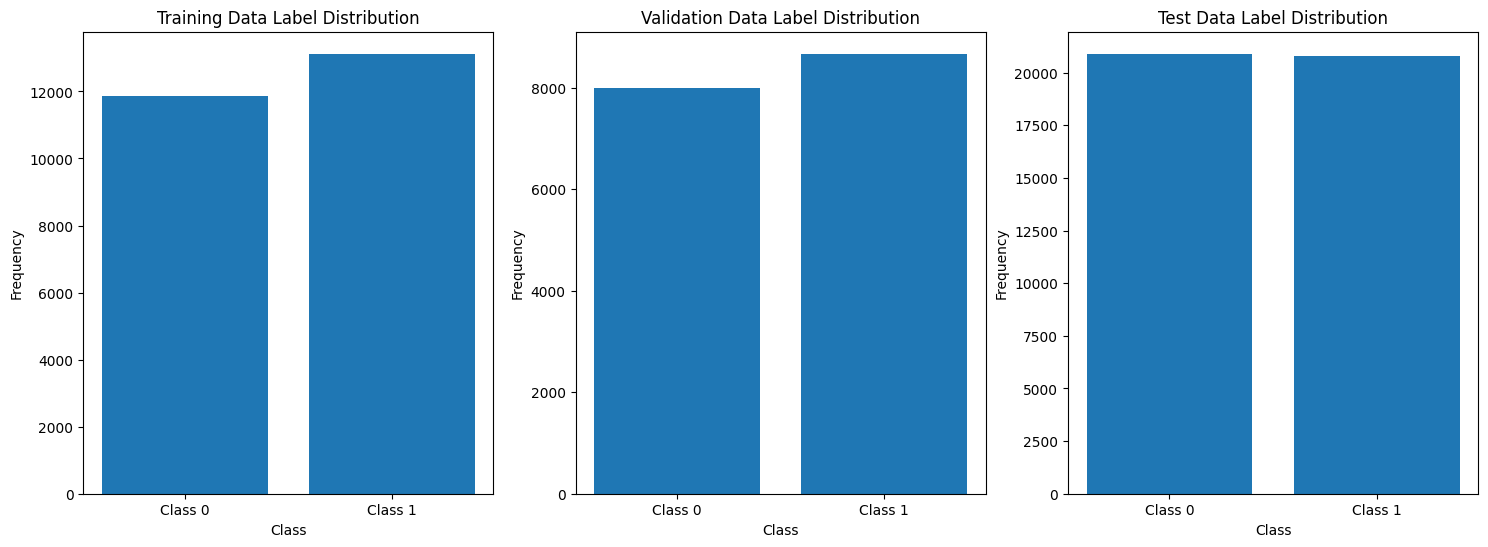

In [14]:
datasets = [train_y, vali_y, test_y]
dataset_names = ['Training', 'Validation', 'Test']

# 가로로 3개의 서브플롯 생성
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (data, name) in enumerate(zip(datasets, dataset_names)):
    unique, counts = np.unique(data, return_counts=True)
    axs[i].bar(unique, counts)
    axs[i].set_title(f'{name} Data Label Distribution')
    axs[i].set_xlabel('Class')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xticks(unique, ['Class 0', 'Class 1'])
    for label, count in zip(unique, counts):
        print(f'{name} data - class {label}: {count}')

plt.show()

In [15]:
target_num = 1

#이것 저것 써보기
custom_optimizer = Adam(learning_rate=-1.01)
custom_optimizer1 = tf.keras.optimizers.RMSprop(learning_rate=0.001) #이거 ACC 잘나옴
custom_optimizer2 = tf.keras.optimizers.Ftrl(learning_rate=0.01)
custom_optimizer3 = tf.keras.optimizers.Adadelta(learning_rate=1.0)
custom_optimizer4 = tf.keras.optimizers.Adagrad(learning_rate=0.001)
custom_optimizer5 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

##MLP

Attention Mechanism 없는 기존 MLP 모델

In [16]:
# 모델 구성 함수 정의
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(222, activation='relu')(inputs)  # 첫 번째 Dense 레이어
    x = Dense(222, activation='relu')(x)       # 두 번째 Dense 레이어
    x = Dense(111, activation='relu')(x)       # 세 번째 Dense 레이어
    outputs = Dense(1, activation='sigmoid')(x)  # 출력 레이어
    model = Model(inputs=inputs, outputs=outputs)
    return model

##MLPA

기존 MLP 모델에 단순히 self-attention Mechanism을 추가한 형태

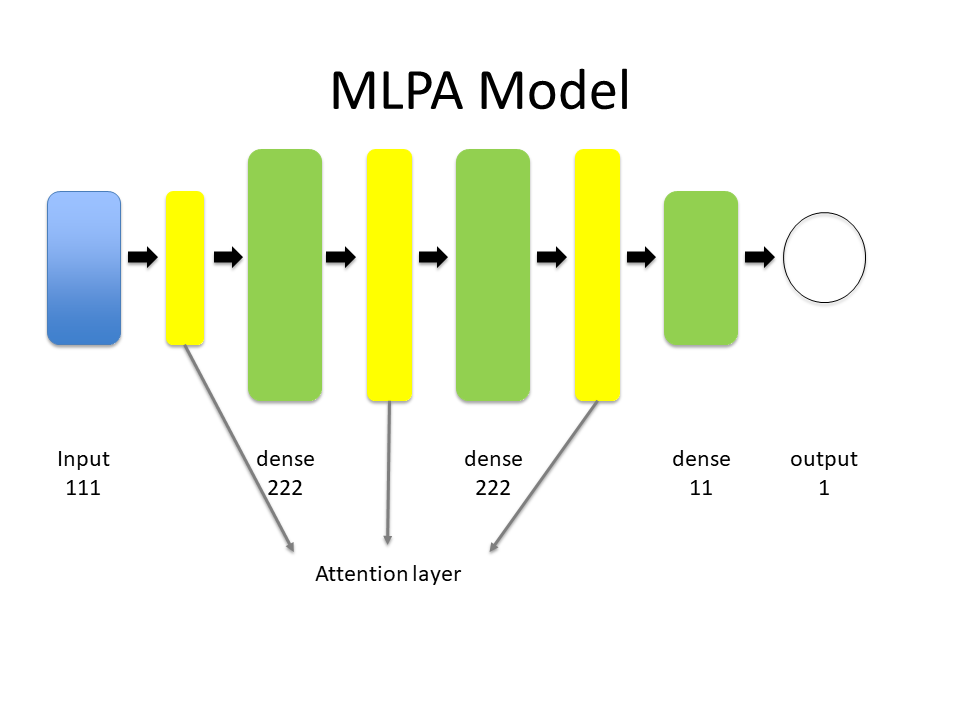

In [17]:
# MLPA 모델 구성 함수 정의
def build_MLPA_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = AttentionLayer()(inputs)
    x = Dense(222, activation='relu')(x)
    x = AttentionLayer()(x)
    x = Dense(222, activation='relu')(x)
    x = AttentionLayer()(x)
    x = Dense(111, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

##MLPAFC

MLPA 모델과 달리 MLP 모델에서 각 레이어 단계에서 attention 값들을 추출한 후에 마지막 output 전에 concat해서 출력(이전 레이어들에는 attention 매커니즘을 통한 학습이 이루어지지 않음, 단순히 attention 값만 추출한 후 output 전에 concat)

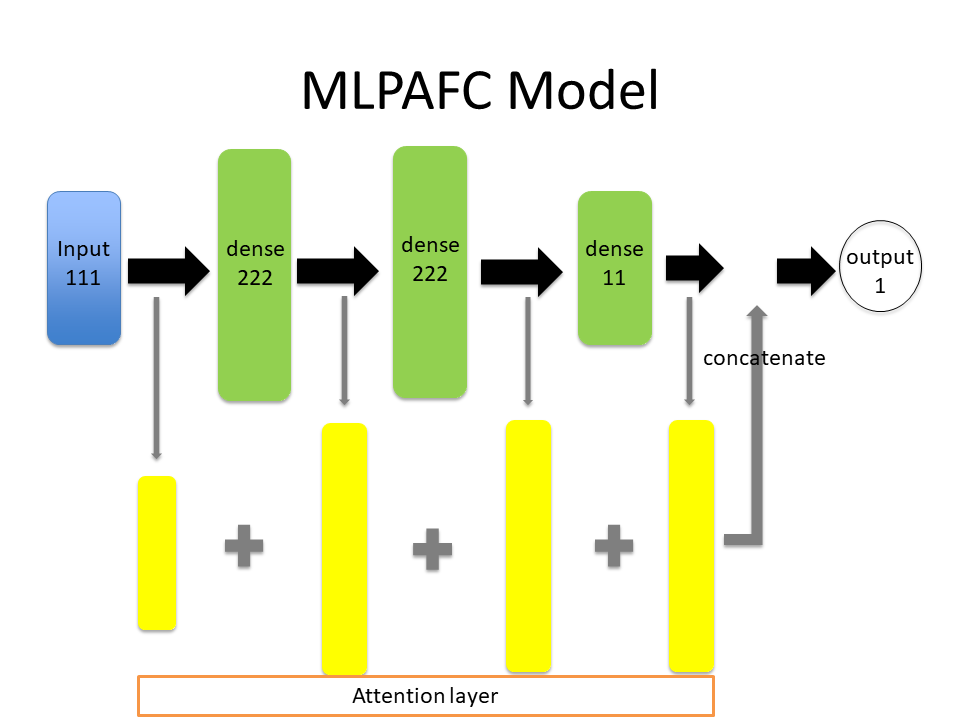

In [18]:
# MLPAFC 모델 구성 함수 정의
def build_MLPAFC_model(input_dim):
    inputs = Input(shape=(input_dim,))
    a0 = AttentionLayer()(inputs)
    x = Dense(222, activation='relu')(inputs)
    a1 = AttentionLayer()(x)
    x = Dense(222, activation='relu')(x)
    a2 = AttentionLayer()(x)
    x = Dense(111, activation='relu')(x)
    a3 = AttentionLayer()(x)
    concatenated = Concatenate()([a0, a1, a2, a3])
    outputs = Dense(1, activation='sigmoid')(concatenated)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111)]             0         
                                                                 
 dense (Dense)               (None, 222)               24864     
                                                                 
 dense_1 (Dense)             (None, 222)               49506     
                                                                 
 dense_2 (Dense)             (None, 111)               24753     
                                                                 
 dense_3 (Dense)             (None, 1)                 112       
                                                                 
Total params: 99235 (387.64 KB)
Trainable params: 99235 (387.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
167/167 [==

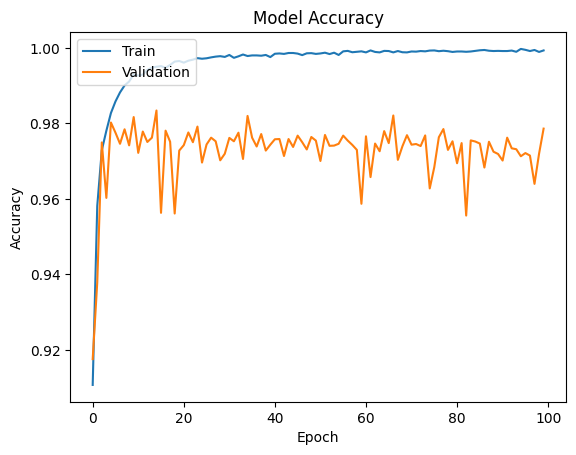

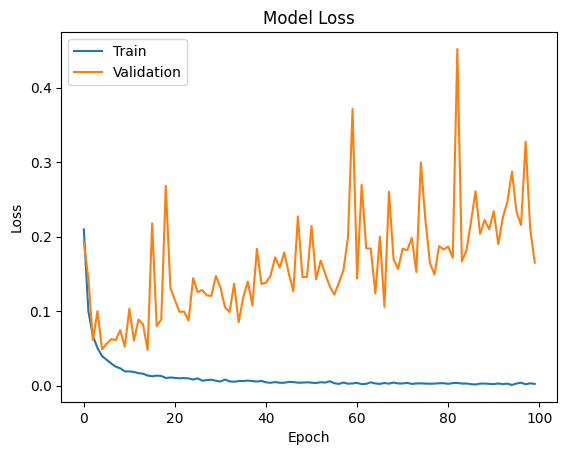

1302/1302 [==============================] - 2s 2ms/step - loss: 0.1072 - accuracy: 0.9820
Model Test metrics (Loss, Accuracy): [0.10723365843296051, 0.9819748401641846]


In [19]:
# 첫 번째 모델 생성 및 컴파일
input_dim = 111
model = build_model(input_dim)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 첫 번째 모델 학습
history = model.fit(train_x, train_y, epochs=100, batch_size=150, validation_data=(vali_x, vali_y))

# 첫 번째 모델 학습 과정 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 첫 번째 모델 테스트
test_metrics = model.evaluate(test_x, test_y, verbose=1)
print("Model Test metrics (Loss, Accuracy):", test_metrics)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 111)]             0         
                                                                 
 attention_layer (Attention  (None, 111)               36963     
 Layer)                                                          
                                                                 
 dense_4 (Dense)             (None, 222)               24864     
                                                                 
 attention_layer_1 (Attenti  (None, 222)               147852    
 onLayer)                                                        
                                                                 
 dense_5 (Dense)             (None, 222)               49506     
                                                                 
 attention_layer_2 (Attenti  (None, 222)               1478

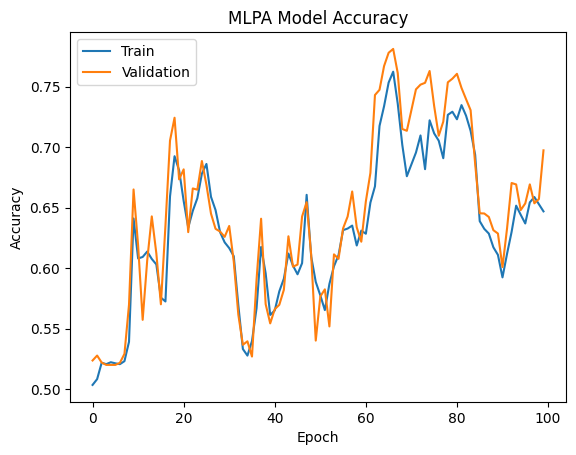

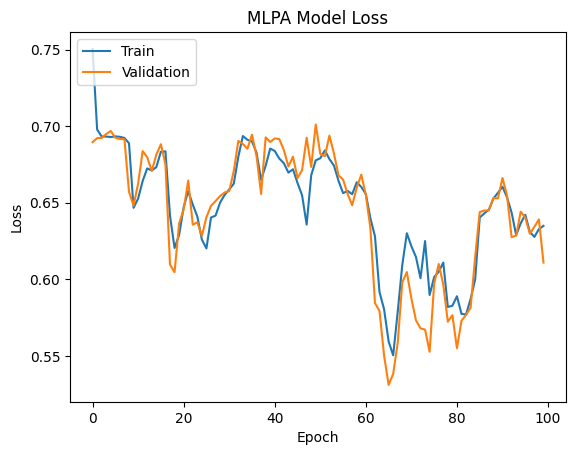

1302/1302 [==============================] - 3s 2ms/step - loss: 0.6084 - accuracy: 0.6993
MLPA Model Test metrics (Loss, Accuracy): [0.6083987951278687, 0.6992607712745667]


In [20]:
# MLPA 모델 생성 및 컴파일
model_MLPA = build_MLPA_model(input_dim)
model_MLPA.compile(optimizer=custom_optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
model_MLPA.summary()

# MLPA 모델 학습
history_MLPA = model_MLPA.fit(train_x, train_y, epochs=100, batch_size=150, validation_data=(vali_x, vali_y))

# MLPA 모델 학습 과정 시각화
plt.plot(history_MLPA.history['accuracy'])
plt.plot(history_MLPA.history['val_accuracy'])
plt.title('MLPA Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_MLPA.history['loss'])
plt.plot(history_MLPA.history['val_loss'])
plt.title('MLPA Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# MLPA 모델 테스트
test_metrics_MLPA = model_MLPA.evaluate(test_x, test_y, verbose=1)
print("MLPA Model Test metrics (Loss, Accuracy):", test_metrics_MLPA)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 111)]                0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 222)                  24864     ['input_3[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 222)                  49506     ['dense_8[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 111)                  24753     ['dense_9[0][0]']             
                                                                                            

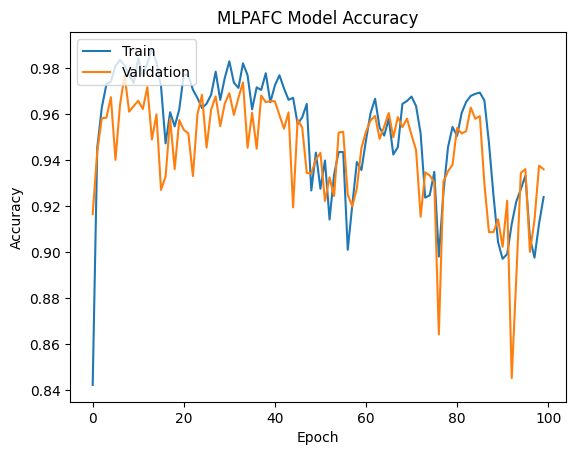

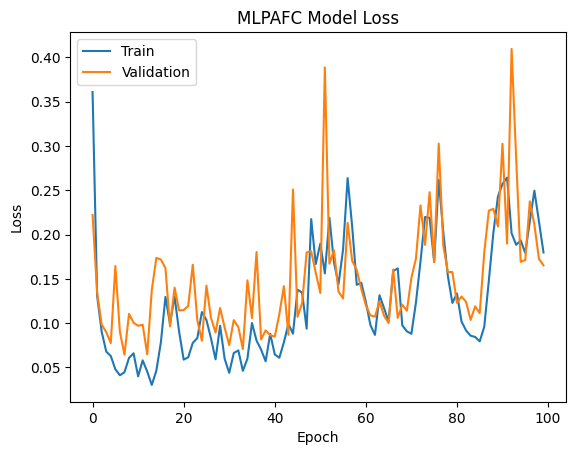

1302/1302 [==============================] - 3s 2ms/step - loss: 0.1982 - accuracy: 0.9278
MLPAFC Model Test metrics (Loss, Accuracy): [0.1982497125864029, 0.9277793765068054]


In [21]:
# MLPAFC 모델 생성 및 컴파일
model_MLPAFC = build_MLPAFC_model(input_dim)
model_MLPAFC.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_MLPAFC.summary()

# MLPAFC 모델 학습
history_MLPAFC = model_MLPAFC.fit(train_x, train_y, epochs=100, batch_size=150, validation_data=(vali_x, vali_y))

# MLPAFC 모델 학습 과정 시각화
plt.plot(history_MLPAFC.history['accuracy'])
plt.plot(history_MLPAFC.history['val_accuracy'])
plt.title('MLPAFC Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_MLPAFC.history['loss'])
plt.plot(history_MLPAFC.history['val_loss'])
plt.title('MLPAFC Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# MLPAFC 모델 테스트
test_metrics_MLPAFC = model_MLPAFC.evaluate(test_x, test_y, verbose=1)
print("MLPAFC Model Test metrics (Loss, Accuracy):", test_metrics_MLPAFC)